In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from statsmodels.tsa.ar_model import AutoReg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [3]:
raw_learn = pd.read_csv('../data/processed/learn.csv')
raw_test = pd.read_csv('../data/processed/test.csv')

raw = pd.read_excel('../data/raw/kadai.xlsx')
raw.shape

(2276, 86)

In [4]:
raw_learn.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [5]:
"""def drop_final_mes_time(df):
    df = df.drop(columns=['final_mes_time'])
    return df

raw_learn = drop_final_mes_time(raw_learn)
raw_test = drop_final_mes_time(raw_test)
raw = drop_final_mes_time(raw)"""

"def drop_final_mes_time(df):\n    df = df.drop(columns=['final_mes_time'])\n    return df\n\nraw_learn = drop_final_mes_time(raw_learn)\nraw_test = drop_final_mes_time(raw_test)\nraw = drop_final_mes_time(raw)"

In [6]:
def df_set_datetime(df, col_name):
    for col in col_name:
        df[col] = pd.to_datetime(df[col])
    return df

raw_learn = df_set_datetime(raw_learn, ["process_end_time", "final_mes_time"])
raw_test = df_set_datetime(raw_test, ["process_end_time", "final_mes_time"])
raw = df_set_datetime(raw, ["process_end_time", "final_mes_time"])
raw.shape

(2276, 86)

In [7]:
# process_end_timeを用いて経過時間, ラグを取得する。

def get_elapsed_day(df, base_time=None):
    if base_time == None:
        base_time = df['process_end_time'].min()
    df['elapsed_day'] = (df['process_end_time'] - base_time).dt.days
    return df

raw_learn = get_elapsed_day(raw_learn)
raw_test = get_elapsed_day(raw_test)
raw = get_elapsed_day(raw)
raw.shape

(2276, 87)

In [8]:
def set_LagOV(df,target="OV", lag_record_num=1, window=3):
    df[f"{target}_lag{lag_record_num}"] = df[target].shift(lag_record_num)
    df[f"{target}_diff"] = df[target].diff(1).shift(1)  
    df[f"{target}_roll_mean{window}"] = df[target].rolling(window).mean().shift(1)
    df[f"{target}_roll_std{window}"] = df[target].rolling(window).std().shift(1)
    #df = df.dropna().reset_index(drop=True)
    return df

raw_learn = set_LagOV(raw_learn)
raw_test = set_LagOV(raw_test)
raw = set_LagOV(raw)
raw.shape

(2276, 91)

In [9]:
raw_learn.head(5)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X79,X80,X81,X82,X83,elapsed_day,OV_lag1,OV_diff,OV_roll_mean3,OV_roll_std3
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,NaN,NaN,NaN,NaN
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,111.2886,NaN,NaN,NaN
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,4.1,0.0,0.01,0.16,0.04,0,201.5617,90.2731,NaN,NaN
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,111.9410,-89.6207,141.597100,51.931891
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,182.3914,70.4504,165.298033,47.192212


In [10]:
raw.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X79,X80,X81,X82,X83,elapsed_day,OV_lag1,OV_diff,OV_roll_mean3,OV_roll_std3
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,NaN,NaN,NaN,NaN
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,111.2886,NaN,NaN,NaN
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,4.1,0.0,0.01,0.16,0.04,0,201.5617,90.2731,NaN,NaN
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,111.9410,-89.6207,141.597100,51.931891
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,182.3914,70.4504,165.298033,47.192212


100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


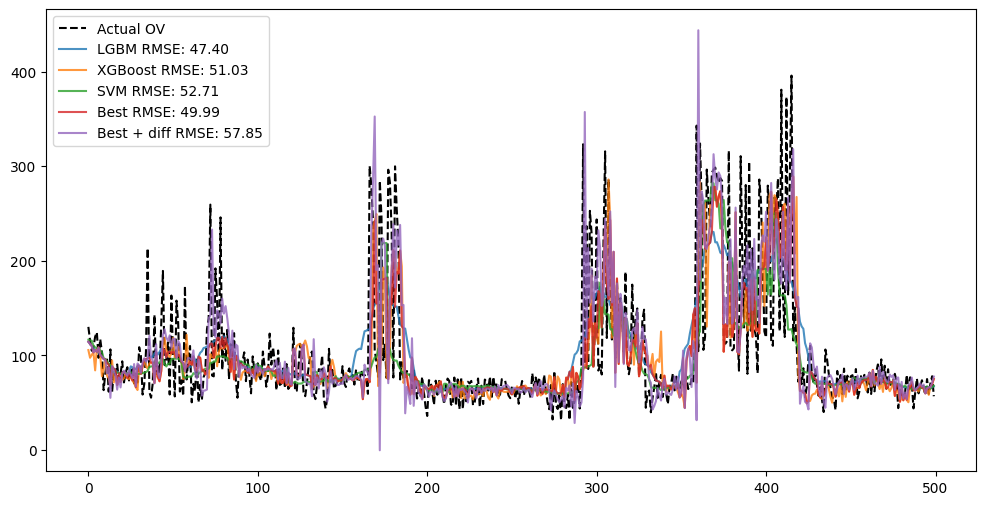

In [22]:
# 使用する特徴量カラム名をリストではなく単純なリストで指定
feature_cols = ["X14", "X30", "X33", "X83", "elapsed_day", "OV_lag1", "OV_diff", "OV_roll_mean3", "OV_roll_std3"]

closs_model = "LGBM"
diff_rmse = 0
yHat = {
  "LGBM": [],
  "XGBoost": [],
  "SVM": [],
  "Best": [],
  "Best + diff": [],
}

scoring = "neg_root_mean_squared_error"

# 1レコードずつtestにしてループ
for i in tqdm.tqdm(range(1776, 2276)):
    # 訓練, テストデータの整形-----------------------------------------------------------
    learn = raw.iloc[0:i]
    test = raw.iloc[i:i+1]
    # インデックスをリセットする
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)
    test_process_end_time = test['process_end_time'].iloc[0]
    #print(test_process_end_time)
    learn = learn[learn["final_mes_time"] < test_process_end_time]
    # testの前後10件のOV分布と等しくなるようにlearnのデータをコピーしてサンプル分布を近づける
    # test_idx: i
    context_window = 10
    test_context_start = max(i - context_window, 0)
    test_context_end = min(i + context_window + 1, len(raw))
    # 前後10件（合計最大21件、重複なし）のインデックス
    test_context_indices = list(range(test_context_start, test_context_end))
    test_context_df = raw.iloc[test_context_indices]

    # learnのOVをtest前後10件のOV分布にできるだけ近づけるよう、learnから各値に最も近いものをコピーして新しいlearn_dsを作成
    from scipy.spatial.distance import cdist

    # 現状のlearnのコピーを保持
    learn_orig = learn.copy()
    # 近似分布用の空リスト
    learn_match_rows = []

    for ov_val in test_context_df['OV']:
        # learnからov_valに最も近いものを探索
        abs_diff = (learn_orig['OV'] - ov_val).abs()
        min_idx = abs_diff.idxmin()
        learn_match_rows.append(learn_orig.loc[min_idx].copy())

    # 新しいlearnデータセット（index振り直し）
    learn = pd.DataFrame(learn_match_rows).reset_index(drop=True)
    # 説明変数と目的変数に分離
    # 学習データ
    X_l = learn[feature_cols]
    Y_l = learn.OV
    # テストデータ
    X_t = test[feature_cols]
    Y_t = test.OV

    # モデリング-----------------------------------------------------------------------
    pipelineLGBM = Pipeline([
        #("selector", SelectFromModel()),
        ("scaler", StandardScaler()),
        ("model", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=42
        ))
    ])
    pipelineXGBoost = Pipeline([
        #("selector", SelectFromModel()),
        ("scaler", StandardScaler()),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8
        ))
    ])

    pipelineSVM = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf"))
    ])

    # 直近10件の予測残渣（OV予測値 - 正解値）から状態空間モデルで今回の残渣を予測する
    if i >= 1786:  # 直近3件が揃うまでは0
        prev_residuals = [
            yHat["Best"][j] - raw["OV"][i+j] for  j in range(-1, -11, -1)
        ]
        # 状態空間モデル(ローカルレベルモデル)で直近10件の残差系列から次の残差を予測する
        prev_residuals_array = np.array(prev_residuals[::-1])
        # SARIMAXを状態空間モデル(ローカルレベル)として使う（trend='n', order=(0,0,0)またはstatespace.SARIMAXでlevel/trend直接指定）
        model_ssm = sm.tsa.UnobservedComponents(prev_residuals_array, level='local level')
        result_ssm = model_ssm.fit(disp=False)
        # 1歩先（=今回）の残差予測
        diff_OV_pred = result_ssm.forecast(steps=1)[0]
    else:
        diff_OV_pred = 0

    pipelineLGBM.fit(X_l, Y_l)
    predLGBM = pipelineLGBM.predict(X_t)

    pipelineXGBoost.fit(X_l, Y_l)
    predXGBoost = pipelineXGBoost.predict(X_t)

    pipelineSVM.fit(X_l, Y_l)
    predSVM = pipelineSVM.predict(X_t)

    yHat["LGBM"].append(predLGBM[0])  # 予測値を格納（1レコードなので[0]）
    yHat["XGBoost"].append(predXGBoost[0])  # 予測値を格納（1レコードなので[0]）
    yHat["SVM"].append(predSVM[0])
    if closs_model == "LGBM":
      yHat["Best"].append(predLGBM[0])
    elif closs_model == "XGBoost":
      yHat["Best"].append(predXGBoost[0])
    else:
      yHat["Best"].append(predSVM[0])

    yHat["Best + diff"].append(yHat["Best"][-1] - diff_OV_pred)
    #次に使うモデルの検討-----------------------------------------------------------------------

    # mean_squared_error の入力は array-like である必要があるため、[] でラップ
    RMSE_SCORE = {
        "LGBM": np.sqrt(mean_squared_error([Y_t.iloc[0]], [yHat["LGBM"][-1]])),
        "XGBoost": np.sqrt(mean_squared_error([Y_t.iloc[0]], [yHat["XGBoost"][-1]])),
        "SVM": np.sqrt(mean_squared_error([Y_t.iloc[0]], [yHat["SVM"][-1]])),
        "Best": np.sqrt(mean_squared_error([Y_t.iloc[0]], [yHat["Best"][-1]]))
    }


    # closs_model（ベストモデル）を決める  
    if np.sqrt(mean_squared_error(Y_t.values, np.array([yHat["LGBM"][-1]]))) < np.sqrt(mean_squared_error(Y_t.values, np.array([yHat["XGBoost"][-1]]))):
        closs_model = "LGBM"
    else:
        closs_model = "XGBoost"


# Y_tは予測値と同じ個数だけ取得する
Y_t = raw["OV"][1776:(1776 + len(yHat["LGBM"]))].reset_index(drop=True).values
plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

for model, yh  in yHat.items():
    rmse = np.sqrt(mean_squared_error(Y_t, yh))
    plt.plot(yh, label=f'{model} RMSE: {rmse:.2f}', alpha=0.8)

plt.legend()
plt.show()

In [15]:
df_Hat = pd.DataFrame(yHat)
df_Hat.head()

,LGBM,XGBoost,GPR,Best,Best + diff
0,108.295643,111.273041,6.824785,108.295643,108.295643
1,112.298175,116.141151,6.824785,116.141151,116.141151
2,106.662143,103.354088,6.824785,103.354088,103.354088
3,113.673022,116.826530,6.824785,116.826530,116.826530
4,111.157780,118.727089,6.824785,111.157780,111.157780


In [ ]:
best_model_rmse = np.sqrt(mean_squared_error(Y_t, yHat["Best"]))

In [ ]:
best_model_rmse

67.30203106204941

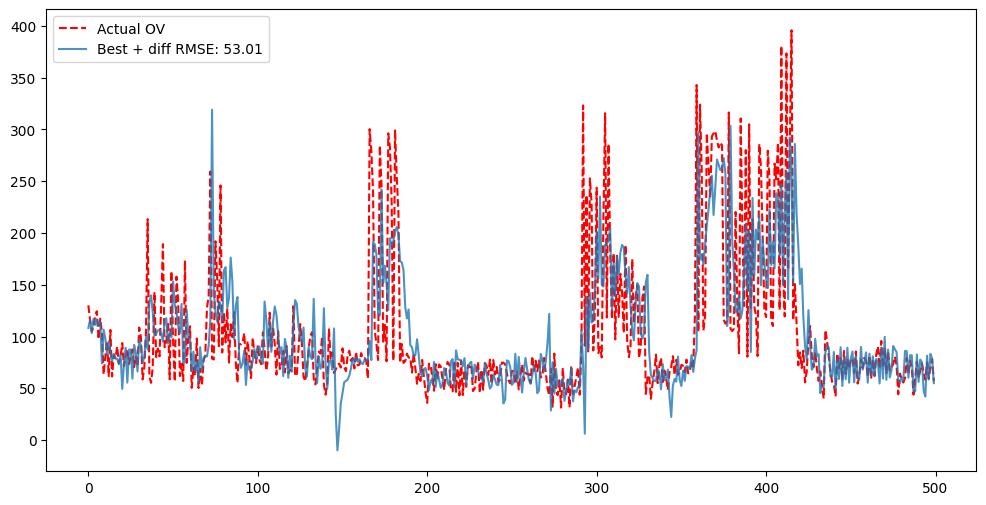

In [17]:

# Y_tは予測値と同じ個数だけ取得する
Y_t = raw["OV"][1776:(1776 + len(yHat["LGBM"]))].reset_index(drop=True).values
plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='red', linestyle='--')

model="Best + diff"
yh = yHat[model]
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'{model} RMSE: {rmse:.2f}', alpha=0.8)

plt.legend()
plt.show()